## 1. Imports and Paths

In [1]:
# Playing with labeled image data
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from helper_functions import overlay_bboxes, HarrisKeypointDetector, SimpleFeatureDescriptor, \
    ORB_SIFT_FeatureDescriptor, color_moments, extract_color_moments

In [2]:
# Define directories
base_dir = '/Users/jetcalz07/Desktop/MIDS/W281_CV/logo_detection_w281/'
image_dir = base_dir + 'data/images/'
bbox_dir = base_dir + 'data/yolofinalset/obj_train_data/'

## Temp

In [3]:
# Load list of train images
with open(base_dir + 'data/yolofinalset/train.txt') as f:
    train = f.readlines()
train = [x.replace('\n', '').split('/')[-1] for x in train]

print(len(train))
print(len(os.listdir(image_dir)))

773
7864


## 2. Load Example for Dev

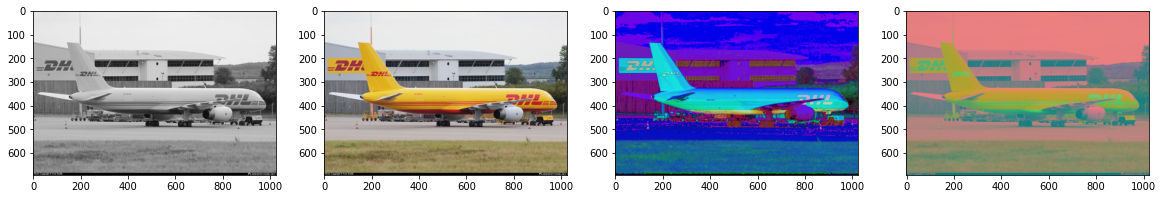

In [4]:
# Load list of train images
with open(base_dir + 'data/yolofinalset/train.txt') as f:
    train = f.readlines()
train = [x.replace('\n', '').split('/')[-1] for x in train]

# Load first image, template, bounding boxes
z = 0
img_file = image_dir + train[z]
img_bbox_file = bbox_dir +  train[z].replace('.jpg', '.txt')

# Load image with different color schemes
im_load = cv2.imread(img_file)
im_gray = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)
im_rgb = cv2.cvtColor(im_load, cv2.COLOR_BGR2RGB)
im_hsv = cv2.cvtColor(im_load, cv2.COLOR_BGR2HSV)
im_ycrcb = cv2.cvtColor(im_load, cv2.COLOR_BGR2YCR_CB)

# visualize
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].imshow(im_gray, cmap='gray')
ax[1].imshow(im_rgb)
ax[2].imshow(im_hsv)
ax[3].imshow(im_ycrcb)
plt.show()

## 3. Given image, bbox file paths.. load img and overlay the bounding boxes

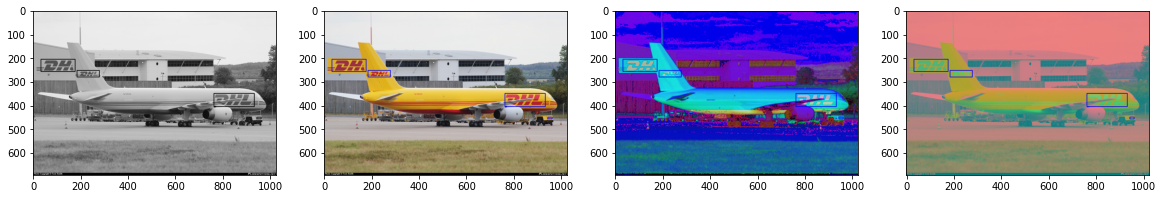

In [5]:
# Extract bbox subset from image for feature extraction
im_gray_bboxes, gray_bboxes = overlay_bboxes(im_gray, img_bbox_file)
im_rgb_bboxes, rgb_bboxes = overlay_bboxes(im_rgb, img_bbox_file)
im_hsv_bboxes, hsv_bboxes = overlay_bboxes(im_hsv, img_bbox_file)
im_ycrcb_bboxes, ycrcb_bboxes = overlay_bboxes(im_ycrcb, img_bbox_file)

# visualize
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].imshow(im_gray_bboxes, cmap='gray')
ax[1].imshow(im_rgb_bboxes)
ax[2].imshow(im_hsv_bboxes)
ax[3].imshow(im_ycrcb_bboxes)
plt.show()

#### 3.1 View each box for image

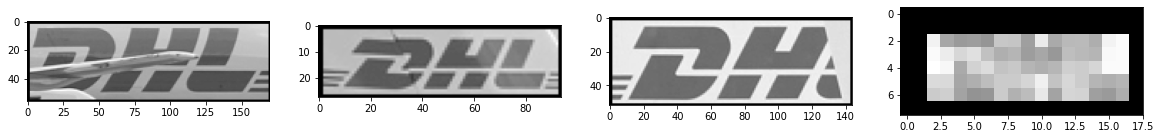

In [6]:
# Extract a single box so that we can extract features
fig, ax = plt.subplots(1, len(gray_bboxes), figsize=(20, 5))

for i in range(len(gray_bboxes)):
    label, x_min, x_max, y_min, y_max = gray_bboxes[i]
    img_bbox = im_gray_bboxes[y_min:y_max, x_min:x_max]
    ax[i].imshow(img_bbox, cmap='gray')

## 4. Feature Extraction - Single Image Example

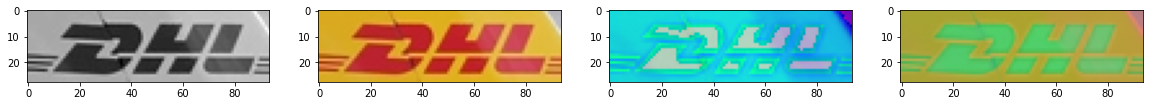

In [7]:
# Extract a single box so that we can extract features
i = 1 # box number
label, x_min, x_max, y_min, y_max = gray_bboxes[i]
img_bbox_gray = im_gray[y_min:y_max, x_min:x_max]
img_bbox_rgb = im_rgb[y_min:y_max, x_min:x_max]
img_bbox_hsv = im_hsv[y_min:y_max, x_min:x_max]
img_bbox_ycrcb = im_ycrcb[y_min:y_max, x_min:x_max]

# visualize
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].imshow(img_bbox_gray, cmap='gray')
ax[1].imshow(img_bbox_rgb)
ax[2].imshow(img_bbox_hsv)
ax[3].imshow(img_bbox_ycrcb)
plt.show()


### 4.1 Feature Extraction - Color Moments

In [8]:
# To append to DF
bbox_cm_rgb = extract_color_moments(img_bbox_rgb)
bbox_cm_hsv = extract_color_moments(img_bbox_hsv)
bbox_cm_ycrcb = extract_color_moments(img_bbox_ycrcb)

## For visual check only
for mom in [0,2,3]:# <---- read paper to learn why these options
  print('moment',mom,'rgb',color_moments(img_bbox_rgb,mom=mom)) # <--- is it ok to use rgb instead of bgr as initially setup?
  print('moment',mom,'hsv',color_moments(img_bbox_hsv,mom=mom))
  print('moment',mom,'ycrcb',color_moments(img_bbox_ycrcb,mom=mom))

moment 0 rgb [210.75038  127.91793   50.036854]
moment 0 hsv [ 40.56497 197.80472 210.7956 ]
moment 0 ycrcb [143.80016 175.76558  75.07599]
moment 2 rgb [22.539858309705632, 58.977960290125125, 28.365580948820654]
moment 2 hsv [57.559782849082325, 31.79085828997581, 22.491808952093088]
moment 2 ycrcb [41.70912118770129, 16.936906444048496, 22.190378970558296]
moment 3 rgb [-17.60054075561355, -47.06080125467377, 34.17947534694123]
moment 3 hsv [71.3215894160669, -42.95040131194688, -17.58867099650612]
moment 3 ycrcb [-32.93018669798095, 10.61953639316704, 16.72212341011303]


### 4.2 Feature Extraction - Harris Corners

In [9]:
# keypoints, feature descriptors
harris_kp = HarrisKeypointDetector(img_bbox, n=2, w=3, k=0.04, p=0.9, verbose=False)
simple_feature = SimpleFeatureDescriptor(img_bbox, harris_kp, w=5)
harris_orb_feature = ORB_SIFT_FeatureDescriptor(img_bbox, use_orb = True, use_harris=True, nfeatures=10, harris_kp=harris_kp)
orb_kp_feature = ORB_SIFT_FeatureDescriptor(img_bbox, use_orb = True, use_harris=False, nfeatures=10, harris_kp=None)
harris_sift_feature = ORB_SIFT_FeatureDescriptor(img_bbox, use_orb = False, use_harris=True, nfeatures=10, harris_kp=harris_kp)
sift_kp_feature = ORB_SIFT_FeatureDescriptor(img_bbox, use_orb = False, use_harris=False, nfeatures=10, harris_kp=None)

## 5. Run all bbox loop, format and append to DF (one row per bbox feature set)

In [10]:
# Init DF
df = pd.DataFrame({
    'img_file': pd.Series(dtype='str'),
    'bbox_file': pd.Series(dtype='str'),
    'label':  pd.Series(dtype='int'),
    'bbox_num': pd.Series(dtype='int'),
    'bbox_corners': pd.Series(dtype='int'),
    'simple_feature': pd.Series(dtype='float32'),
    'harris_orb_feature': pd.Series(dtype='float32'),
    'orb_kp_feature': pd.Series(dtype='float32'),
    'harris_sift_feature': pd.Series(dtype='float32'),
    'sift_kp_feature': pd.Series(dtype='float32'),
    })

# Load first image, template, bounding boxes
for z in range(len(train)):
    img_file = image_dir + train[z]
    img_bbox_file = bbox_dir +  train[z].replace('.jpg', '.txt')

    # Load image, overlay bboxes
    #im_gray, im_bboxes, bboxes, label = overlay_bboxes(img_file, img_bbox_file)
    im_gray_bboxes, gray_bboxes = overlay_bboxes(im_gray, img_bbox_file)
    im_rgb_bboxes, rgb_bboxes = overlay_bboxes(im_rgb, img_bbox_file)
    im_hsv_bboxes, hsv_bboxes = overlay_bboxes(im_hsv, img_bbox_file)
    im_ycrcb_bboxes, ycrcb_bboxes = overlay_bboxes(im_ycrcb, img_bbox_file)

    # loop through each box, get features and append to df row
    for i in range(len(gray_bboxes)):
        label, x_min, x_max, y_min, y_max = gray_bboxes[i]
        img_bbox_gray = im_gray[y_min:y_max, x_min:x_max]
        img_bbox_rgb = im_rgb[y_min:y_max, x_min:x_max]
        img_bbox_hsv = im_hsv[y_min:y_max, x_min:x_max]
        img_bbox_ycrcb = im_ycrcb[y_min:y_max, x_min:x_max]

        # get keyopints and feature descriptors
        harris_kp = HarrisKeypointDetector(img_bbox_gray, n=2, w=3, k=0.04, p=0.9, verbose=False)
        simple_feature = SimpleFeatureDescriptor(img_bbox_gray, harris_kp, w=5)
        harris_orb_feature = ORB_SIFT_FeatureDescriptor(img_bbox_gray, use_orb = True, use_harris=True, nfeatures=10, harris_kp=harris_kp)
        orb_kp_feature = ORB_SIFT_FeatureDescriptor(img_bbox_gray, use_orb = True, use_harris=False, nfeatures=10, harris_kp=None)
        harris_sift_feature = ORB_SIFT_FeatureDescriptor(img_bbox_gray, use_orb = False, use_harris=True, nfeatures=10, harris_kp=harris_kp)
        sift_kp_feature = ORB_SIFT_FeatureDescriptor(img_bbox_gray, use_orb = False, use_harris=False, nfeatures=10, harris_kp=None)

        # get color moments
        cm_rgb_mean, cm_rgb_var, cm_rgb_skew = extract_color_moments(img_bbox_rgb)
        cm_hsv_mean, cm_hsv_var, cm_hsv_skew = extract_color_moments(img_bbox_hsv)
        cm_ycrcb_mean, cm_ycrcb_var, cm_ycrcb_skew = extract_color_moments(img_bbox_ycrcb)
        # unpack indiv moments
        cm_rgb_mean_1, cm_rgb_mean_2, cm_rgb_mean_3 = cm_rgb_mean
        cm_rgb_var_1, cm_rgb_var_2, cm_rgb_var_3 = cm_rgb_var
        cm_rgb_skew_1, cm_rgb_skew_2, cm_rgb_skew_3 = cm_rgb_skew
        cm_hsv_mean_1, cm_hsv_mean_2, cm_hsv_mean_3 = cm_hsv_mean
        cm_hsv_var_1, cm_hsv_var_2, cm_hsv_var_3 = cm_hsv_var
        cm_hsv_skew_1, cm_hsv_skew_2, cm_hsv_skew_3 = cm_hsv_skew
        cm_ycrcb_mean_1, cm_ycrcb_mean_2, cm_ycrcb_mean_3 = cm_ycrcb_mean
        cm_ycrcb_var_1, cm_ycrcb_var_2, cm_ycrcb_var_3 = cm_ycrcb_var
        cm_ycrcb_skew_1, cm_ycrcb_skew_2, cm_ycrcb_skew_3 = cm_ycrcb_skew
        
        # append to df
        row = {
            'img_file': train[z],
            'bbox_file': train[z].replace('.jpg', '.txt'),
            'label': label,
            'bbox_num': i+1,
            'bbox_corners': np.array(gray_bboxes, dtype='int'),
            'simple_feature': simple_feature,
            'harris_orb_feature': harris_orb_feature,
            'orb_kp_feature': orb_kp_feature,
            'harris_sift_feature': harris_sift_feature,
            'sift_kp_feature': sift_kp_feature,
            'cm_rgb_mean': cm_rgb_mean,
            'cm_rgb_var': cm_rgb_var,
            'cm_rgb_skew': cm_rgb_skew,
            'cm_hsv_mean': cm_hsv_mean,
            'cm_hsv_var': cm_hsv_var,
            'cm_hsv_skew': cm_hsv_skew,
            'cm_ycrcb_mean': cm_ycrcb_mean,
            'cm_ycrcb_var': cm_ycrcb_var,
            'cm_ycrcb_skew': cm_ycrcb_skew,
            }
        df = df.append(row, ignore_index=True)

# display
print(len(df))
df.head()

1641


,img_file,bbox_file,label,bbox_num,bbox_corners,simple_feature,harris_orb_feature,orb_kp_feature,harris_sift_feature,sift_kp_feature,cm_hsv_0,cm_hsv_2,cm_hsv_3,cm_rgb_0,cm_rgb_2,cm_rgb_3,cm_ycrcb_0,cm_ycrcb_2,cm_ycrcb_3
0,002837.jpg,002837.txt,1.0,1,"[[1, 762, 932, 347, 403], [1, 185, 279, 250, 2...","[[196.0, 193.0, 195.0, 198.0, 198.0, 130.0, 12...","[[134, 69, 30, 175, 13, 66, 54, 40, 172, 132, ...","[[93, 229, 27, 160, 213, 222, 109, 101, 160, 1...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 3.0, 5.0, 1.0, 27.0, 17.0, 4.0, 1.0, 11...","[76.49485, 162.83781, 199.68802]","[73.71675845905325, 67.9637041561294, 36.54168...","[57.57648613303671, -76.54733687916887, -39.21...","[198.84003, 121.79107, 73.20924]","[37.08143059480818, 61.253716609134244, 44.857...","[-39.48401557006493, -23.93970058436079, 51.63...","[139.3022, 170.47731, 90.70788]","[44.41095040800821, 24.43668525078755, 28.1218...","[16.23894911389937, -16.547448131172395, -11.1..."
1,002837.jpg,002837.txt,1.0,2,"[[1, 762, 932, 347, 403], [1, 185, 279, 250, 2...","[[152.0, 164.0, 176.0, 172.0, 172.0, 165.0, 12...","[[144, 87, 14, 189, 8, 82, 28, 44, 164, 158, 1...","[[40, 167, 150, 102, 237, 51, 196, 125, 192, 1...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 3.0, 106.0, 105.0, 0.0, 0.0, 0.0, ...","[40.56497, 197.80472, 210.7956]","[57.559782849082325, 31.79085828997581, 22.491...","[71.3215894160669, -42.95040131194688, -17.588...","[210.75038, 127.91793, 50.036854]","[22.539858309705632, 58.977960290125125, 28.36...","[-17.60054075561355, -47.06080125467377, 34.17...","[143.80016, 175.76558, 75.07599]","[41.70912118770129, 16.936906444048496, 22.190...","[-32.93018669798095, 10.61953639316704, 16.722..."
2,002837.jpg,002837.txt,1.0,3,"[[1, 762, 932, 347, 403], [1, 185, 279, 250, 2...","[[173.0, 175.0, 179.0, 181.0, 180.0, 177.0, 16...","[[148, 18, 62, 161, 162, 90, 146, 0, 44, 173, ...","[[97, 41, 121, 68, 100, 217, 101, 39, 105, 64,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 8.0, 82.0, 129.0, 1.0, 0.0, 1.0, 3...","[74.71514, 185.4809, 187.13329]","[75.35372550845354, 14.159383823225301, 33.018...","[62.24148576695548, 12.54813329495731, -12.359...","[187.13329, 112.9801, 57.11966]","[33.01873372893843, 59.98636333986114, 13.5509...","[-12.359833569820141, -23.849289930128954, -10...","[128.76869, 169.66412, 87.51522]","[44.67886867883496, 8.721935190194534, 27.7669...","[-16.772304345523, 4.030293608057289, 10.95970..."
3,002837.jpg,002837.txt,1.0,4,"[[1, 762, 932, 347, 403], [1, 185, 279, 250, 2...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[221, 201, 194, 100, 98, 224, 82, 83, 51, 212...",None,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",None,"[13.805555, 164.52083, 214.80556]","[5.6288909724959995, 11.316144287159105, 14.71...","[-2.758756208887799, 7.932613003426183, -12.59...","[214.80556, 141.17361, 76.791664]","[14.713126120811868, 32.85222169493596, 13.805...","[-12.595696747937655, -19.500441157819047, -9....","[155.82639, 170.07639, 83.395836]","[23.92590700159091, 9.20679086712624, 10.32743...","[-17.145156899783824, -1.5324069146049777, 1.8..."
4,002836.jpg,002836.txt,1.0,1,"[[1, 751, 773, 304, 310], [1, 827, 849, 297, 3...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[40, 10, 135, 68, 193, 150, 130, 48, 144, 172...",None,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",None,"[83.51515, 26.060606, 165.59091]","[33.98584483604119, 16.03866402761779, 55.5224...","[-29.66964127611604, 16.138206485285544, -44.6...","[155.7197, 160.34091, 160.35606]","[50.60816714450697, 51.48813184012101, 62.4849...","[-40.12239568816436, -41.86260314284869, -51.3...","[158.98485, 125.69697, 128.72728]","[52.41833256231456, 2.27282828058429, 6.207389...","[-42.37529191000863, -1.6605741283684736, -5.5..."


In [11]:
df.to_pickle(base_dir+'data/feature_sets/feature_set_v110922.csv')
test = pd.read_pickle(base_dir+'data/feature_sets/feature_set_v110922.csv')
test.head()

,img_file,bbox_file,label,bbox_num,bbox_corners,simple_feature,harris_orb_feature,orb_kp_feature,harris_sift_feature,sift_kp_feature,cm_hsv_0,cm_hsv_2,cm_hsv_3,cm_rgb_0,cm_rgb_2,cm_rgb_3,cm_ycrcb_0,cm_ycrcb_2,cm_ycrcb_3
0,002837.jpg,002837.txt,1.0,1,"[[1, 762, 932, 347, 403], [1, 185, 279, 250, 2...","[[196.0, 193.0, 195.0, 198.0, 198.0, 130.0, 12...","[[134, 69, 30, 175, 13, 66, 54, 40, 172, 132, ...","[[93, 229, 27, 160, 213, 222, 109, 101, 160, 1...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 3.0, 5.0, 1.0, 27.0, 17.0, 4.0, 1.0, 11...","[76.49485, 162.83781, 199.68802]","[73.71675845905325, 67.9637041561294, 36.54168...","[57.57648613303671, -76.54733687916887, -39.21...","[198.84003, 121.79107, 73.20924]","[37.08143059480818, 61.253716609134244, 44.857...","[-39.48401557006493, -23.93970058436079, 51.63...","[139.3022, 170.47731, 90.70788]","[44.41095040800821, 24.43668525078755, 28.1218...","[16.23894911389937, -16.547448131172395, -11.1..."
1,002837.jpg,002837.txt,1.0,2,"[[1, 762, 932, 347, 403], [1, 185, 279, 250, 2...","[[152.0, 164.0, 176.0, 172.0, 172.0, 165.0, 12...","[[144, 87, 14, 189, 8, 82, 28, 44, 164, 158, 1...","[[40, 167, 150, 102, 237, 51, 196, 125, 192, 1...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 3.0, 106.0, 105.0, 0.0, 0.0, 0.0, ...","[40.56497, 197.80472, 210.7956]","[57.559782849082325, 31.79085828997581, 22.491...","[71.3215894160669, -42.95040131194688, -17.588...","[210.75038, 127.91793, 50.036854]","[22.539858309705632, 58.977960290125125, 28.36...","[-17.60054075561355, -47.06080125467377, 34.17...","[143.80016, 175.76558, 75.07599]","[41.70912118770129, 16.936906444048496, 22.190...","[-32.93018669798095, 10.61953639316704, 16.722..."
2,002837.jpg,002837.txt,1.0,3,"[[1, 762, 932, 347, 403], [1, 185, 279, 250, 2...","[[173.0, 175.0, 179.0, 181.0, 180.0, 177.0, 16...","[[148, 18, 62, 161, 162, 90, 146, 0, 44, 173, ...","[[97, 41, 121, 68, 100, 217, 101, 39, 105, 64,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 8.0, 82.0, 129.0, 1.0, 0.0, 1.0, 3...","[74.71514, 185.4809, 187.13329]","[75.35372550845354, 14.159383823225301, 33.018...","[62.24148576695548, 12.54813329495731, -12.359...","[187.13329, 112.9801, 57.11966]","[33.01873372893843, 59.98636333986114, 13.5509...","[-12.359833569820141, -23.849289930128954, -10...","[128.76869, 169.66412, 87.51522]","[44.67886867883496, 8.721935190194534, 27.7669...","[-16.772304345523, 4.030293608057289, 10.95970..."
3,002837.jpg,002837.txt,1.0,4,"[[1, 762, 932, 347, 403], [1, 185, 279, 250, 2...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[221, 201, 194, 100, 98, 224, 82, 83, 51, 212...",None,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",None,"[13.805555, 164.52083, 214.80556]","[5.6288909724959995, 11.316144287159105, 14.71...","[-2.758756208887799, 7.932613003426183, -12.59...","[214.80556, 141.17361, 76.791664]","[14.713126120811868, 32.85222169493596, 13.805...","[-12.595696747937655, -19.500441157819047, -9....","[155.82639, 170.07639, 83.395836]","[23.92590700159091, 9.20679086712624, 10.32743...","[-17.145156899783824, -1.5324069146049777, 1.8..."
4,002836.jpg,002836.txt,1.0,1,"[[1, 751, 773, 304, 310], [1, 827, 849, 297, 3...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[40, 10, 135, 68, 193, 150, 130, 48, 144, 172...",None,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",None,"[83.51515, 26.060606, 165.59091]","[33.98584483604119, 16.03866402761779, 55.5224...","[-29.66964127611604, 16.138206485285544, -44.6...","[155.7197, 160.34091, 160.35606]","[50.60816714450697, 51.48813184012101, 62.4849...","[-40.12239568816436, -41.86260314284869, -51.3...","[158.98485, 125.69697, 128.72728]","[52.41833256231456, 2.27282828058429, 6.207389...","[-42.37529191000863, -1.6605741283684736, -5.5..."


In [12]:
cm_rgb_mean, cm_rgb_var, cm_rgb_skew = extract_color_moments(img_bbox_rgb)

In [15]:
a, b, c = cm_rgb_mean
print(cm_rgb_mean)
print(a)

[68.965   68.10375 59.78875]
68.965


In [22]:
np.split(cm_rgb_mean, len(cm_rgb_mean))

[array([68.965], dtype=float32),
 array([68.10375], dtype=float32),
 array([59.78875], dtype=float32)]

In [27]:
df['cm_rgb_0'].apply(lambda x: np.split(x, 3, axis=0))

0        [[198.84003], [121.79107], [73.20924]]
1       [[210.75038], [127.91793], [50.036854]]
2         [[187.13329], [112.9801], [57.11966]]
3       [[214.80556], [141.17361], [76.791664]]
4        [[155.7197], [160.34091], [160.35606]]
                         ...                   
1636    [[218.53848], [221.98582], [225.82118]]
1637     [[205.4638], [210.12077], [215.01915]]
1638     [[188.41942], [144.36195], [74.23924]]
1639     [[188.02176], [156.26355], [99.62192]]
1640         [[68.965], [68.10375], [59.78875]]
Name: cm_rgb_0, Length: 1641, dtype: object